# Data Preprocessing

## 0. Preprocess Plan 
1. Preprocess `SEP-28k_labels.csv` file
 - Create new column including unique audio id (Show-EpId-ClipId)
 - Create isStutter columns
 - Encode Interjection, NaturalPause, Music columns 
 - Drop rows in which Unsure, PoorAudioQuality, DifficultToUnderstand, noSpeech is not 0
 - Drop unused columns
2. Preprocess audio files
 - Use MCFF
3. Output x and y
 - mcff results to pickle file
 - two y data to y_two_reviewer.csv and y_all_reviewer.csv
4. Output preprocessed SEP-28k_labels to csv 

### Your file structure should look like below :
&#x2757; Make sure you put `clips` folder outside of Smooth-Talk-Squad folder

In [1]:
'''
├── clips
    ├── HeStutters_0_0.wav
└── Smooth-Talk-Squad
    ├── raw_data
        ├── SEP-28k_labels.csv
    └── notebooks
        ├── data-processing.ipynb
''';

In [2]:
! pip install pandas as 
! pip install numpy
! pip install tqdm
! pip install librosa

ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as


## 1. Preprocess `SEP-28k_labels.csv` file

In [3]:
import numpy as np
import pandas as pd

In [4]:
data_sep28k_labels = pd.read_csv('../raw_data/SEP-28k_labels.csv', dtype={'EpId':str})

In [5]:
data_sep28k_labels.head(5)

,Show,EpId,ClipId,Start,Stop,Unsure,PoorAudioQuality,Prolongation,Block,SoundRep,WordRep,DifficultToUnderstand,Interjection,NoStutteredWords,NaturalPause,Music,NoSpeech
0,HeStutters,0,0,31900320,31948320,0,0,0,0,0,0,0,0,3,1,0,0
1,HeStutters,0,1,31977120,32025120,0,0,0,0,0,0,0,0,3,1,0,0
2,HeStutters,0,2,34809760,34857760,0,0,0,0,0,0,0,0,3,0,0,0
3,HeStutters,0,3,35200640,35248640,0,0,1,0,0,0,0,0,2,0,0,0
4,HeStutters,0,4,35721920,35769920,0,0,0,0,0,0,0,0,3,0,0,0


In [6]:
data_sep28k_labels.shape

(28177, 17)

In [7]:
data_sep28k_labels[72:100]

,Show,EpId,ClipId,Start,Stop,Unsure,PoorAudioQuality,Prolongation,Block,SoundRep,WordRep,DifficultToUnderstand,Interjection,NoStutteredWords,NaturalPause,Music,NoSpeech
72,HeStutters,1,32,31661920,31709920,0,0,3,0,0,0,0,3,0,0,0,0
73,HeStutters,1,33,31802080,31850080,0,0,0,1,3,0,0,0,0,0,0,0
74,HeStutters,1,34,31838240,31886240,0,0,0,0,1,1,1,1,1,0,0,0
75,HeStutters,1,35,31881600,31929600,0,0,1,1,2,0,1,0,0,0,0,0
76,HeStutters,1,36,31917440,31965440,0,0,0,1,0,0,0,3,2,0,0,0
77,HeStutters,1,37,5095680,5143680,0,0,0,2,3,0,1,1,0,0,0,0
78,HeStutters,1,38,31963680,32011680,0,0,0,1,0,0,0,0,2,0,0,0
79,HeStutters,1,39,32034720,32082720,0,0,0,1,1,0,0,2,1,1,0,0
80,HeStutters,1,40,32086560,32134560,0,0,2,1,0,0,2,0,0,0,0,0
81,HeStutters,1,41,32346240,32394240,0,1,2,1,0,0,0,1,1,0,0,0


In [8]:
fluencybank_labels = pd.read_csv('../raw_data/fluencybank_labels.csv', dtype={'EpId':str})

In [9]:
fluencybank_labels["EpId"] = fluencybank_labels["EpId"].str.strip()

In [10]:
fluencybank_labels.head(5)

,Show,EpId,ClipId,Start,Stop,Unsure,PoorAudioQuality,Prolongation,Block,SoundRep,WordRep,DifficultToUnderstand,Interjection,NoStutteredWords,NaturalPause,Music,NoSpeech
0,FluencyBank,010,0,88960,136960,0,0,0,1,0,0,0,0,2,0,0,0
1,FluencyBank,010,1,1271520,1319520,0,0,0,0,0,0,0,0,3,0,0,0
2,FluencyBank,010,2,1813760,1861760,0,0,1,0,0,0,0,0,2,0,0,0
3,FluencyBank,010,3,1842720,1890720,0,0,1,0,0,0,0,0,2,1,0,0
4,FluencyBank,010,4,1893280,1941280,0,0,0,0,0,3,0,0,0,0,0,0


In [11]:
fluencybank_labels.shape

(4144, 17)

In [12]:
data_sep28k_labels = pd.concat([data_sep28k_labels, fluencybank_labels], axis=0)

In [13]:
data_sep28k_labels.shape

(32321, 17)

In [14]:
data_sep28k_labels[data_sep28k_labels['Show'].str.contains('FluencyBank')==True]

,Show,EpId,ClipId,Start,Stop,Unsure,PoorAudioQuality,Prolongation,Block,SoundRep,WordRep,DifficultToUnderstand,Interjection,NoStutteredWords,NaturalPause,Music,NoSpeech
0,FluencyBank,010,0,88960,136960,0,0,0,1,0,0,0,0,2,0,0,0
1,FluencyBank,010,1,1271520,1319520,0,0,0,0,0,0,0,0,3,0,0,0
2,FluencyBank,010,2,1813760,1861760,0,0,1,0,0,0,0,0,2,0,0,0
3,FluencyBank,010,3,1842720,1890720,0,0,1,0,0,0,0,0,2,1,0,0
4,FluencyBank,010,4,1893280,1941280,0,0,0,0,0,3,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4139,FluencyBank,985,191,13483520,13531520,0,0,0,1,0,0,0,0,2,0,0,0
4140,FluencyBank,985,192,13517280,13565280,0,0,0,2,1,0,0,0,0,1,0,0
4141,FluencyBank,985,193,13568960,13616960,0,0,0,2,2,1,0,0,0,1,0,0
4142,FluencyBank,985,194,1683520,1731520,0,0,0,0,3,0,0,1,0,0,0,0


In [15]:
data_sep28k_labels[data_sep28k_labels['Show'].str.contains('FluencyBank')==False]

,Show,EpId,ClipId,Start,Stop,Unsure,PoorAudioQuality,Prolongation,Block,SoundRep,WordRep,DifficultToUnderstand,Interjection,NoStutteredWords,NaturalPause,Music,NoSpeech
0,HeStutters,0,0,31900320,31948320,0,0,0,0,0,0,0,0,3,1,0,0
1,HeStutters,0,1,31977120,32025120,0,0,0,0,0,0,0,0,3,1,0,0
2,HeStutters,0,2,34809760,34857760,0,0,0,0,0,0,0,0,3,0,0,0
3,HeStutters,0,3,35200640,35248640,0,0,1,0,0,0,0,0,2,0,0,0
4,HeStutters,0,4,35721920,35769920,0,0,0,0,0,0,0,0,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28172,WomenWhoStutter,109,35,25793600,25841600,0,0,0,0,0,0,0,3,3,0,0,0
28173,WomenWhoStutter,109,36,26168480,26216480,0,0,1,1,3,0,1,1,0,0,0,0
28174,WomenWhoStutter,109,37,3569440,3617440,0,0,0,0,0,0,0,3,3,1,0,0
28175,WomenWhoStutter,109,38,28479840,28527840,0,0,1,0,0,0,0,3,2,1,0,0


### Look into dataset

In [16]:
data_sep28k_labels.shape

(32321, 17)

In [17]:
data_sep28k_labels.columns

Index(['Show', 'EpId', 'ClipId', 'Start', 'Stop', 'Unsure', 'PoorAudioQuality',
       'Prolongation', 'Block', 'SoundRep', 'WordRep', 'DifficultToUnderstand',
       'Interjection', 'NoStutteredWords', 'NaturalPause', 'Music',
       'NoSpeech'],
      dtype='object')

In [18]:
data_sep28k_labels[["Unsure"]].value_counts()

Unsure
0         31344
1           938
2            37
3             2
dtype: int64

In [19]:
data_sep28k_labels[["PoorAudioQuality"]].value_counts()

PoorAudioQuality
0                   29411
1                    2328
2                     481
3                     101
dtype: int64

In [20]:
data_sep28k_labels[["DifficultToUnderstand"]].value_counts()

DifficultToUnderstand
0                        26998
1                         4161
2                          992
3                          170
dtype: int64

In [21]:
data_sep28k_labels[["NoSpeech"]].value_counts()

NoSpeech
0           31346
1             667
2             178
3             130
dtype: int64

In [22]:
data_sep28k_labels[["Prolongation"]].value_counts()

Prolongation
0               22839
1                6332
2                2239
3                 911
dtype: int64

### Create unique audio id column 'Name'

In [23]:
data_sep28k_labels['Name'] = data_sep28k_labels[data_sep28k_labels.columns[0:3]].apply(
    lambda x: '_'.join(x.dropna().astype(str)),
    axis=1
)
data_sep28k_labels.head()

,Show,EpId,ClipId,Start,Stop,Unsure,PoorAudioQuality,Prolongation,Block,SoundRep,WordRep,DifficultToUnderstand,Interjection,NoStutteredWords,NaturalPause,Music,NoSpeech,Name
0,HeStutters,0,0,31900320,31948320,0,0,0,0,0,0,0,0,3,1,0,0,HeStutters_0_0
1,HeStutters,0,1,31977120,32025120,0,0,0,0,0,0,0,0,3,1,0,0,HeStutters_0_1
2,HeStutters,0,2,34809760,34857760,0,0,0,0,0,0,0,0,3,0,0,0,HeStutters_0_2
3,HeStutters,0,3,35200640,35248640,0,0,1,0,0,0,0,0,2,0,0,0,HeStutters_0_3
4,HeStutters,0,4,35721920,35769920,0,0,0,0,0,0,0,0,3,0,0,0,HeStutters_0_4


### Create isStutter columns

1. 'isStutter_by_all_reviewers' column : NoStutteredWords is 1 or 2 or 3 (1 or more reviewers think it is stuttered) 
2. 'isStutter_by_2_more_reviewers' column : NoStutteredWords is 2 or 3 (at least 2 reviewers think it is stuttered) 

In [24]:
# data_sep28k_labels['isStutter_by_any_reviewers'] = ""
data_sep28k_labels['isStutter_by_2_more_reviewers'] = ""

In [25]:
data_sep28k_labels.loc[data_sep28k_labels["NoStutteredWords"] <= 1.0, "isStutter_by_2_more_reviewers"] = 1
data_sep28k_labels.loc[data_sep28k_labels["NoStutteredWords"] >= 2.0, "isStutter_by_2_more_reviewers"] = 0
data_sep28k_labels[["isStutter_by_2_more_reviewers"]].value_counts(normalize=True)

isStutter_by_2_more_reviewers
0                                0.565824
1                                0.434176
dtype: float64

In [26]:
# data_sep28k_labels.head(20)

In [27]:
# data_sep28k_labels.loc[data_sep28k_labels["NoStutteredWords"] < 3.0, "isStutter_by_any_reviewers"] = 1
# data_sep28k_labels.loc[data_sep28k_labels["NoStutteredWords"] == 3.0, "isStutter_by_any_reviewers"] = 0
# data_sep28k_labels[["isStutter_by_any_reviewers"]].value_counts()

In [28]:
# def isStutter(data):
#     if data["Prolongation"] >= 2: 
#         return True
#     if data["Prolongation"] >= 2: 
#         return True
#     if data["Prolongation"] >= 2: 
#         return True

# Check if any of the classes (Prolongation, Block, SoundRep, WordRep) is 2 or more
# conditions = (data_sep28k_labels['Prolongation'] >= 2) | (data_sep28k_labels['Block'] >= 2) | (data_sep28k_labels['SoundRep'] >= 2) | (data_sep28k_labels['WordRep'] >= 2)

# # Set StutterFlag column based on the conditions
# data_sep28k_labels['StutterFlag'] = conditions.astype(int)

# data_sep28k_labels

In [29]:
data_sep28k_labels.head(30)

,Show,EpId,ClipId,Start,Stop,Unsure,PoorAudioQuality,Prolongation,Block,SoundRep,WordRep,DifficultToUnderstand,Interjection,NoStutteredWords,NaturalPause,Music,NoSpeech,Name,isStutter_by_2_more_reviewers
0,HeStutters,0,0,31900320,31948320,0,0,0,0,0,0,0,0,3,1,0,0,HeStutters_0_0,0
1,HeStutters,0,1,31977120,32025120,0,0,0,0,0,0,0,0,3,1,0,0,HeStutters_0_1,0
2,HeStutters,0,2,34809760,34857760,0,0,0,0,0,0,0,0,3,0,0,0,HeStutters_0_2,0
3,HeStutters,0,3,35200640,35248640,0,0,1,0,0,0,0,0,2,0,0,0,HeStutters_0_3,0
4,HeStutters,0,4,35721920,35769920,0,0,0,0,0,0,0,0,3,0,0,0,HeStutters_0_4,0
5,HeStutters,0,5,36435040,36483040,0,0,1,0,0,0,0,0,2,0,0,0,HeStutters_0_5,0
6,HeStutters,0,6,37251200,37299200,0,0,0,0,0,0,0,0,3,0,0,0,HeStutters_0_6,0
7,HeStutters,0,7,37784640,37832640,0,0,0,0,0,0,0,0,3,2,0,0,HeStutters_0_7,0
8,HeStutters,0,8,37963520,38011520,0,0,0,0,0,0,0,0,3,2,0,0,HeStutters_0_8,0
9,HeStutters,0,9,41417440,41465440,0,0,0,0,0,0,0,0,3,0,0,0,HeStutters_0_9,0


In [30]:
print(data_sep28k_labels[data_sep28k_labels['Name'].str.contains('FluencyBank')==True]["Name"])

0         FluencyBank_010_0
1         FluencyBank_010_1
2         FluencyBank_010_2
3         FluencyBank_010_3
4         FluencyBank_010_4
               ...         
4139    FluencyBank_985_191
4140    FluencyBank_985_192
4141    FluencyBank_985_193
4142    FluencyBank_985_194
4143    FluencyBank_985_195
Name: Name, Length: 4144, dtype: object


### Encode stutter features

In [31]:
data_sep28k_labels['ProlongationEncoded'] = ""
data_sep28k_labels['BlockEncoded'] = ""
data_sep28k_labels['SoundRepEncoded'] = ""
data_sep28k_labels['WordRepEncoded'] = ""

In [32]:
data_sep28k_labels[["Prolongation"]].value_counts()

Prolongation
0               22839
1                6332
2                2239
3                 911
dtype: int64

In [33]:
data_sep28k_labels.loc[data_sep28k_labels["Prolongation"] > 1.0, "ProlongationEncoded"] = 1
data_sep28k_labels.loc[data_sep28k_labels["Prolongation"] <= 1.0, "ProlongationEncoded"] = 0
data_sep28k_labels[["ProlongationEncoded"]].value_counts(normalize=True)

ProlongationEncoded
0                      0.90254
1                      0.09746
dtype: float64

In [34]:
data_sep28k_labels[["Block"]].value_counts()

Block
0        18865
1         9658
2         3206
3          592
dtype: int64

In [35]:
data_sep28k_labels.loc[data_sep28k_labels["Block"] > 1.0, "BlockEncoded"] = 1
data_sep28k_labels.loc[data_sep28k_labels["Block"] <= 1.0, "BlockEncoded"] = 0
data_sep28k_labels[["BlockEncoded"]].value_counts(normalize=True)

BlockEncoded
0               0.882491
1               0.117509
dtype: float64

In [36]:
data_sep28k_labels[["SoundRep"]].value_counts()

SoundRep
0           25559
1            3871
2            1851
3            1040
dtype: int64

In [37]:
data_sep28k_labels.loc[data_sep28k_labels["SoundRep"] > 1.0, "SoundRepEncoded"] = 1
data_sep28k_labels.loc[data_sep28k_labels["SoundRep"] <= 1.0, "SoundRepEncoded"] = 0
data_sep28k_labels[["SoundRepEncoded"]].value_counts(normalize=True)

SoundRepEncoded
0                  0.910554
1                  0.089446
dtype: float64

In [38]:
data_sep28k_labels[["WordRep"]].value_counts(normalize=True)

WordRep
0          0.827945
1          0.073048
3          0.056805
2          0.042202
dtype: float64

In [39]:
data_sep28k_labels.loc[data_sep28k_labels["WordRep"] > 1.0, "WordRepEncoded"] = 1
data_sep28k_labels.loc[data_sep28k_labels["WordRep"] <= 1.0, "WordRepEncoded"] = 0
data_sep28k_labels[["WordRepEncoded"]].value_counts(normalize=True)

WordRepEncoded
0                 0.900993
1                 0.099007
dtype: float64

### Encode Interjection, NaturalPause, Music columns

In [40]:
data_sep28k_labels.shape

(32321, 23)

In [41]:
# from sklearn.preprocessing import Binarizer
# column_names = ["Music", "Interjection", "NaturalPause"]
# column_names_after_encoded = ["MusicEncoded", "InterjectionEncoded", "NaturalPauseEncoded"]
# temp_data = data_sep28k_labels[column_names]
# binarizer = Binarizer(threshold=0.0).fit(temp_data)
# temp_data_binarizered = pd.DataFrame(binarizer.transform(temp_data), columns=column_names_after_encoded)
# temp_data_binarizered.shape

In [42]:
# data_sep28k_labels = pd.concat([data_sep28k_labels, temp_data_binarizered], axis=1)

In [43]:
data_sep28k_labels[["Music"]].value_counts() # For comparison purpose

Music
0        31925
3          199
2           99
1           98
dtype: int64

In [44]:
# data_sep28k_labels[["MusicEncoded"]].value_counts() # For comparison purpose

In [45]:
# data_sep28k_labels.drop(column_names, axis=1,inplace=True)

### Drop rows in which Unsure, PoorAudioQuality, DifficultToUnderstand, NoSpeech is not 0

In [46]:
data_sep28k_labels.shape

(32321, 23)

In [47]:
data_sep28k_labels = data_sep28k_labels[data_sep28k_labels["Unsure"] == 0]
data_sep28k_labels = data_sep28k_labels[data_sep28k_labels["PoorAudioQuality"] == 0]
data_sep28k_labels = data_sep28k_labels[data_sep28k_labels["DifficultToUnderstand"] == 0]
data_sep28k_labels = data_sep28k_labels[data_sep28k_labels["NoSpeech"] == 0]

data_sep28k_labels.shape

(24714, 23)

### Drop rows in which music is more than 0

In [48]:
data_sep28k_labels = data_sep28k_labels[data_sep28k_labels["Music"] == 0]

data_sep28k_labels.shape

(24475, 23)

### Drop unused columns

In [49]:
# data_sep28k_labels.drop(['Prolongation', 'Block', 'SoundRep', 'WordRep', 'NoStutteredWords'], axis=1,inplace=True)
# data_sep28k_labels.drop(['NoStutteredWords'], axis=1,inplace=True)
data_sep28k_labels.drop(['Unsure', 'PoorAudioQuality', 'DifficultToUnderstand', 'NoSpeech'], axis=1, inplace=True)
data_sep28k_labels.drop(['Show', 'EpId', 'ClipId', 'Start', 'Stop'], axis=1, inplace=True)


In [50]:
data_sep28k_labels.shape

(24475, 14)

In [51]:
data_sep28k_labels.head(30)

,Prolongation,Block,SoundRep,WordRep,Interjection,NoStutteredWords,NaturalPause,Music,Name,isStutter_by_2_more_reviewers,ProlongationEncoded,BlockEncoded,SoundRepEncoded,WordRepEncoded
0,0,0,0,0,0,3,1,0,HeStutters_0_0,0,0,0,0,0
1,0,0,0,0,0,3,1,0,HeStutters_0_1,0,0,0,0,0
2,0,0,0,0,0,3,0,0,HeStutters_0_2,0,0,0,0,0
3,1,0,0,0,0,2,0,0,HeStutters_0_3,0,0,0,0,0
4,0,0,0,0,0,3,0,0,HeStutters_0_4,0,0,0,0,0
5,1,0,0,0,0,2,0,0,HeStutters_0_5,0,0,0,0,0
6,0,0,0,0,0,3,0,0,HeStutters_0_6,0,0,0,0,0
7,0,0,0,0,0,3,2,0,HeStutters_0_7,0,0,0,0,0
8,0,0,0,0,0,3,2,0,HeStutters_0_8,0,0,0,0,0
9,0,0,0,0,0,3,0,0,HeStutters_0_9,0,0,0,0,0


In [52]:
data_sep28k_labels[data_sep28k_labels['isStutter_by_2_more_reviewers']==1]

,Prolongation,Block,SoundRep,WordRep,Interjection,NoStutteredWords,NaturalPause,Music,Name,isStutter_by_2_more_reviewers,ProlongationEncoded,BlockEncoded,SoundRepEncoded,WordRepEncoded
27,0,1,3,1,1,0,0,0,HeStutters_0_27,1,0,0,1,0
33,2,1,0,0,0,1,0,0,HeStutters_0_33,1,1,0,0,0
45,0,0,0,3,1,0,0,0,HeStutters_1_5,1,0,0,0,1
48,0,0,0,2,0,1,0,0,HeStutters_1_8,1,0,0,0,1
53,0,1,0,1,0,1,1,0,HeStutters_1_13,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4137,1,2,1,1,0,0,0,0,FluencyBank_985_189,1,0,1,0,0
4138,1,2,2,0,0,0,0,0,FluencyBank_985_190,1,0,1,1,0
4140,0,2,1,0,0,0,1,0,FluencyBank_985_192,1,0,1,0,0
4141,0,2,2,1,0,0,1,0,FluencyBank_985_193,1,0,1,1,0


### DROP data from StrongVoices and StutteringIsCool 

- StrongVoices is no longer anymore
- We might add StutteringIsCool back later once we have time to download them

In [53]:
data_sep28k_labels = data_sep28k_labels[data_sep28k_labels["Name"].str.contains('StrongVoices') == False]
data_sep28k_labels = data_sep28k_labels[data_sep28k_labels["Name"].str.contains('StutteringIsCool') == False]

In [54]:
data_sep28k_labels.shape

(19916, 14)

In [55]:
data_sep28k_labels.tail(30)

,Prolongation,Block,SoundRep,WordRep,Interjection,NoStutteredWords,NaturalPause,Music,Name,isStutter_by_2_more_reviewers,ProlongationEncoded,BlockEncoded,SoundRepEncoded,WordRepEncoded
4109,1,0,0,0,0,2,0,0,FluencyBank_985_161,0,0,0,0,0
4110,0,0,0,0,0,3,0,0,FluencyBank_985_162,0,0,0,0,0
4111,0,0,0,0,0,3,0,0,FluencyBank_985_163,0,0,0,0,0
4112,0,0,0,3,1,0,0,0,FluencyBank_985_164,1,0,0,0,1
4113,0,1,1,2,1,0,0,0,FluencyBank_985_165,1,0,0,0,1
4114,0,0,0,0,2,3,0,0,FluencyBank_985_166,0,0,0,0,0
4115,0,3,0,0,1,0,1,0,FluencyBank_985_167,1,0,1,0,0
4116,0,1,0,0,0,2,1,0,FluencyBank_985_168,0,0,0,0,0
4117,0,0,0,0,0,3,0,0,FluencyBank_985_169,0,0,0,0,0
4118,0,0,0,3,0,0,0,0,FluencyBank_985_170,1,0,0,0,1


In [56]:
data_sep28k_labels[data_sep28k_labels['Name'].str.contains('FluencyBank_010_4')==True]

,Prolongation,Block,SoundRep,WordRep,Interjection,NoStutteredWords,NaturalPause,Music,Name,isStutter_by_2_more_reviewers,ProlongationEncoded,BlockEncoded,SoundRepEncoded,WordRepEncoded
4,0,0,0,3,0,0,0,0,FluencyBank_010_4,1,0,0,0,1
40,0,0,0,0,3,3,1,0,FluencyBank_010_40,0,0,0,0,0
41,0,0,0,0,3,3,0,0,FluencyBank_010_41,0,0,0,0,0
42,0,0,0,0,0,3,0,0,FluencyBank_010_42,0,0,0,0,0
43,0,0,0,0,0,3,1,0,FluencyBank_010_43,0,0,0,0,0
44,0,0,0,0,0,3,1,0,FluencyBank_010_44,0,0,0,0,0
45,0,0,0,0,0,3,1,0,FluencyBank_010_45,0,0,0,0,0
46,0,0,0,0,0,3,0,0,FluencyBank_010_46,0,0,0,0,0
47,0,0,0,0,0,3,1,0,FluencyBank_010_47,0,0,0,0,0
48,0,0,0,0,0,3,0,0,FluencyBank_010_48,0,0,0,0,0


## 2. Audio File Data Process

In [57]:
import librosa
import numpy as np
from tqdm.notebook import tqdm
import os

In [58]:
# clips_list

In [59]:
clips_list = list(data_sep28k_labels["Name"])
len(clips_list)

19916

In [60]:
# print(clips_list)

In [155]:
directory = os.path.join(os.pardir,os.pardir, 'clips_test') # clips folder is not in Smooth-Talk-Squad folder
'''
├── clips
    ├── HeStutters_0_0.wav
└── Smooth-Talk-Squad
    ├── raw_data
        ├── SEP-28k_labels.csv
    └── notebooks
        ├── data-processing.ipynb
'''
features=[]
ignore_list = []
# y_any_reviewer_list =[]
y_two_reviewer_list =[]
y_stutter_feature_list = pd.DataFrame([])
# y_stutter_flag_list = []
clip_name_list = []
mean_for_each_feature_list=[]
mean_for_each_miniclip_list=[]


for filename in tqdm(os.listdir(directory)):
    filename = filename[:-4] # Remove file extension (.wav in our situation)
    if clips_list.count(filename) > 0:
            audio, sample_rate = librosa.load(os.path.join(directory, filename) + '.wav', sr=8000)
            mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=20)
            print(mfccs.T.shape) # (n_mfcc, track_duration)
            
            mfccs_mean_for_each_feature = np.mean(mfccs.T,axis=0)
            print(mfccs_mean_for_each_feature.shape)

            mfccs_mean_for_each_miniclip = np.mean(mfccs,axis=0)
            print(mfccs_mean_for_each_miniclip.shape)
        
            # print(mfccs.shape)
            if mfccs.shape == (20,47):
                features.append(mfccs)
                mean_for_each_feature_list.append(mfccs_mean_for_each_feature)
                mean_for_each_miniclip_list.append(mfccs_mean_for_each_miniclip)
                # y_any_reviewer = data_sep28k_labels[data_sep28k_labels["Name"] == filename]["isStutter_by_any_reviewers"]
                # y_any_reviewer_list.append(y_two_reviewer.astype(int))
                y_two_reviewer = data_sep28k_labels[data_sep28k_labels["Name"] == filename]["isStutter_by_2_more_reviewers"]
                y_two_reviewer_list.append(y_two_reviewer.astype(int))
                
                y_stutter_feature = data_sep28k_labels[data_sep28k_labels["Name"] == filename][['ProlongationEncoded', 'BlockEncoded', 'SoundRepEncoded', 'WordRepEncoded']]
                # print(type(y_stutter_feature))
                y_stutter_feature_list = pd.concat([y_stutter_feature_list, y_stutter_feature])
                
                clip_name = data_sep28k_labels[data_sep28k_labels["Name"] == filename]["Name"]
                # print(f"{clip_name}")
                clip_name_list.append(clip_name)
                # print(f"{filename}")
                # print(f"{y_any_reviewer}")
                # print(f"{y_two_reviewer}")
                # print(f"{y_stutter_feature}")
                # y_stutter_flag = data_sep28k_labels[data_sep28k_labels["Name"] == filename]["StutterFlag"]
                # y_stutter_flag_list.append(y_stutter_flag.astype(int))
                
                
            else:
                print(f"{filename}:{mfccs.shape}")


  0%|          | 0/12 [00:00<?, ?it/s]

(47, 20)
(20,)
(47,)
(47, 20)
(20,)
(47,)
(47, 20)
(20,)
(47,)
(47, 20)
(20,)
(47,)
(47, 20)
(20,)
(47,)
(47, 20)
(20,)
(47,)
(47, 20)
(20,)
(47,)
(47, 20)
(20,)
(47,)
(47, 20)
(20,)
(47,)
(47, 20)
(20,)
(47,)


In [116]:
# y_stutter_flag_list

In [156]:
y_stutter_feature_np = np.array(y_stutter_feature_list)

In [157]:
y_stutter_feature_np.shape

(10, 4)

In [158]:
y_stutter_feature_np

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=object)

In [159]:
# y_stutter_flag_np = np.array(y_stutter_flag_list)
# y_stutter_flag_np

In [121]:
# y_stutter_flag_np.shape

In [122]:
# y_any_reviewer_np = np.array(y_any_reviewer_list)

In [123]:
# y_any_reviewer_np

In [124]:
# y_any_reviewer_np.shape

In [160]:
clip_name_list_np = np.array(clip_name_list)

In [161]:
clip_name_list_np

array([['StutterTalk_63_109'],
       ['StutterTalk_12_9'],
       ['WomenWhoStutter_50_240'],
       ['StutterTalk_68_74'],
       ['HeStutters_0_2'],
       ['HeStutters_0_0'],
       ['HeStutters_0_1'],
       ['FluencyBank_010_1'],
       ['FluencyBank_010_0'],
       ['FluencyBank_010_2']], dtype=object)

In [162]:
clip_name_list_np.shape

(10, 1)

In [148]:
! pip install matplotlib

In [163]:
import matplotlib.pyplot as plt

In [164]:
mean_for_each_feature_list_np = np.array(mean_for_each_feature_list)

In [165]:
mean_for_each_feature_list_np.shape

(10, 20)

In [166]:
mean_for_each_feature_list_np[0]

array([-3.2425830e+02, -1.3311219e+00, -1.6656048e+01, -2.7818424e+01,
       -1.3077422e+01, -1.8826593e+01, -2.2223698e+01,  1.9470562e+00,
       -6.8812475e+00, -1.2145395e+00, -3.1436973e+00, -1.1070944e+01,
       -9.4525623e+00, -4.3309350e+00,  1.8113644e+00,  7.2899027e+00,
        2.3741646e+00, -2.2637756e+00, -4.1946406e+00,  1.5171322e-01],
      dtype=float32)

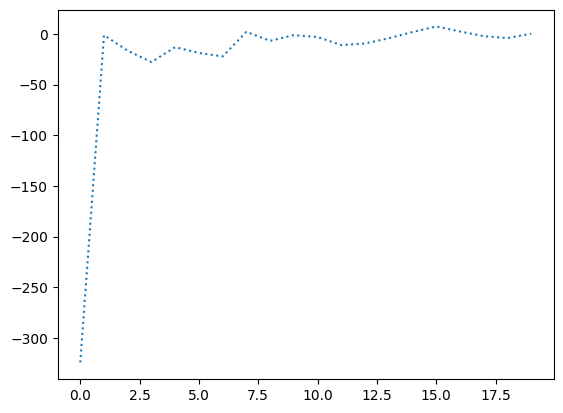

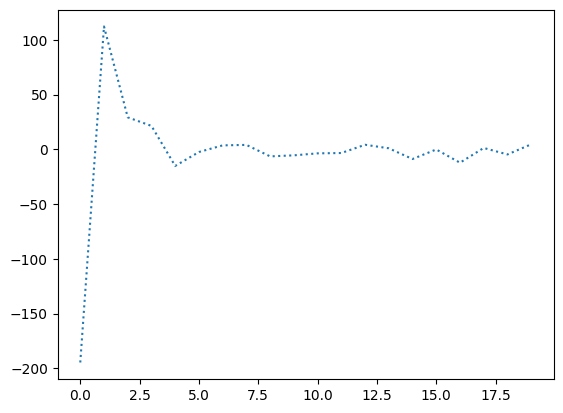

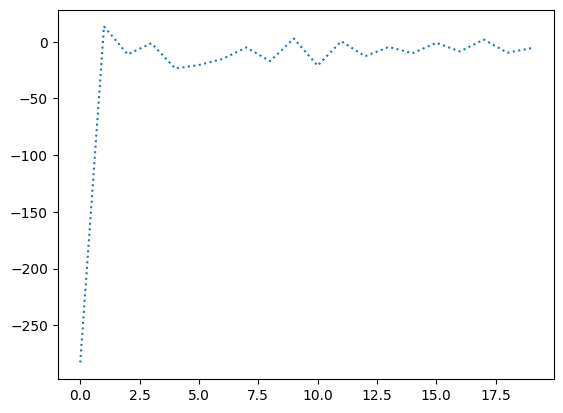

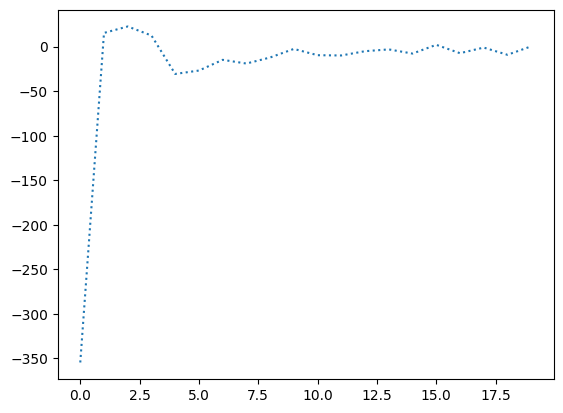

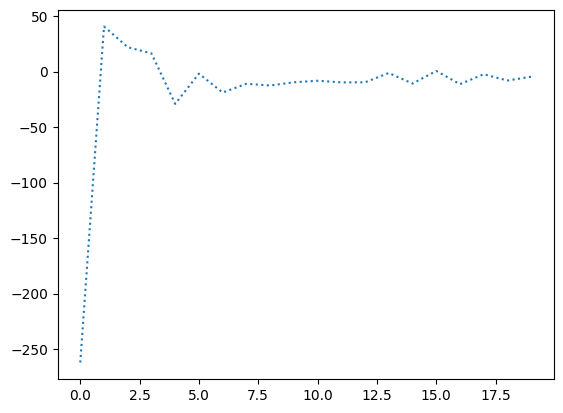

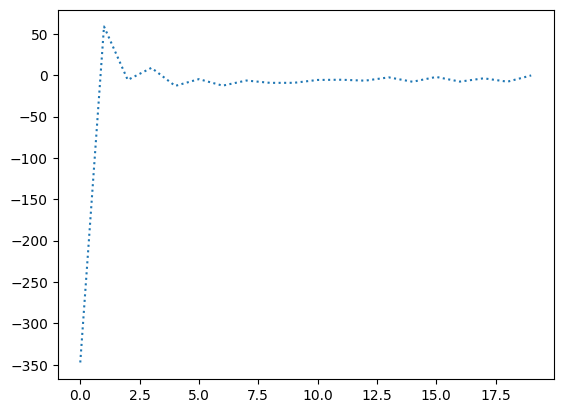

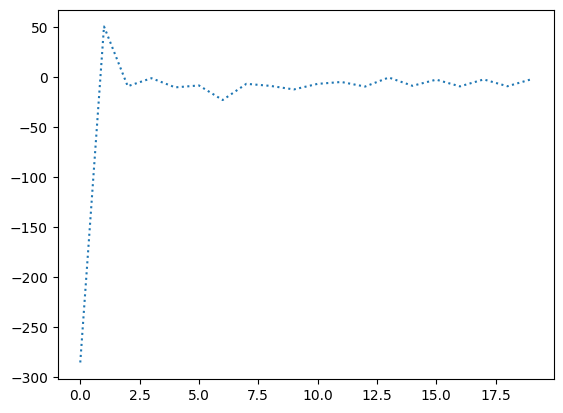

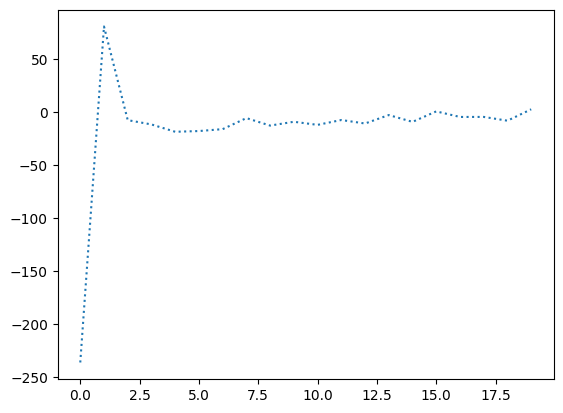

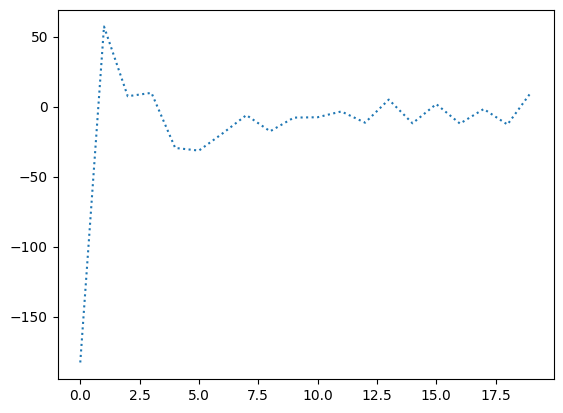

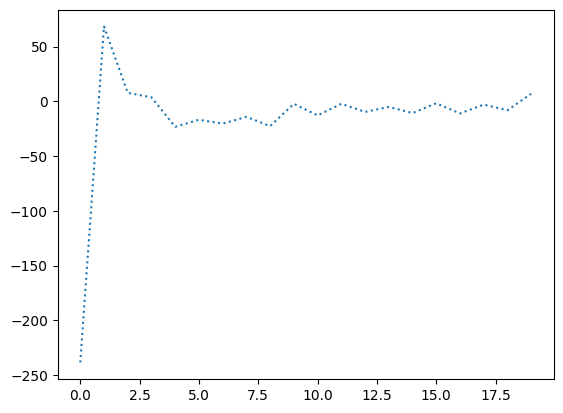

In [174]:
for index in range(10):
    plt.plot(mean_for_each_feature_list_np[index], linestyle = 'dotted')
    plt.show()

In [168]:
mean_for_each_miniclip_list_np = np.array(mean_for_each_miniclip_list)

In [169]:
mean_for_each_miniclip_list_np.shape

(10, 47)

In [170]:
mean_for_each_miniclip_list_np[0]

array([-28.7804  , -28.810675, -29.373188, -29.754482, -29.83053 ,
       -30.298697, -30.201624, -29.967371, -30.392368, -30.321451,
       -30.562815, -30.255728, -30.269373, -30.309147, -29.657658,
       -24.793322, -15.058565, -14.279762, -18.200588, -20.582396,
       -19.733463, -14.207776, -13.520473, -15.472967, -18.13798 ,
       -19.508968, -19.291023, -20.037022, -17.197802, -15.854523,
       -15.412694, -17.391563, -21.65773 , -22.66173 , -22.130856,
       -22.544193, -23.556866, -23.46655 , -23.113232, -22.040249,
       -22.52262 , -22.986216, -23.077854, -21.29901 , -19.502148,
       -17.971272,  -8.951871], dtype=float32)

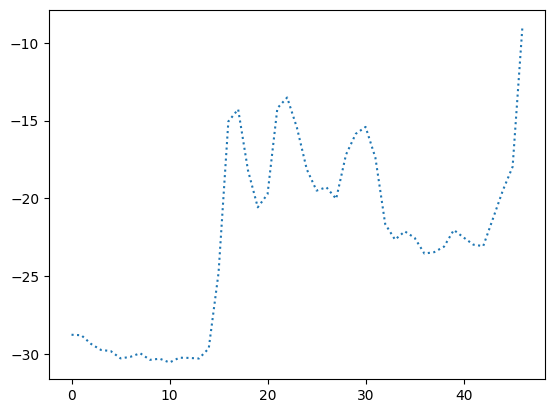

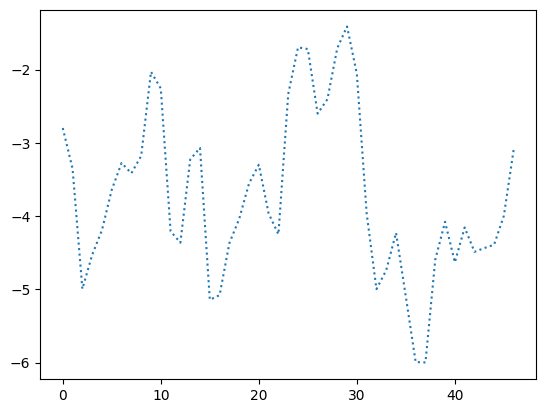

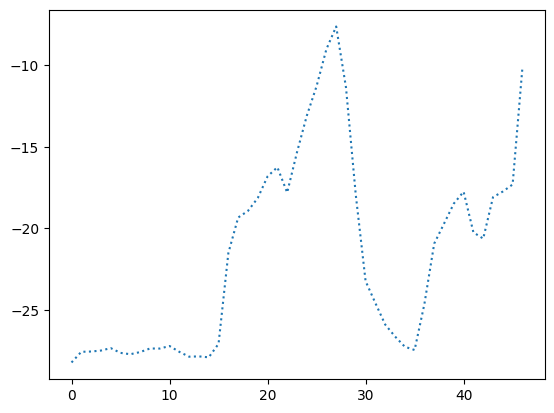

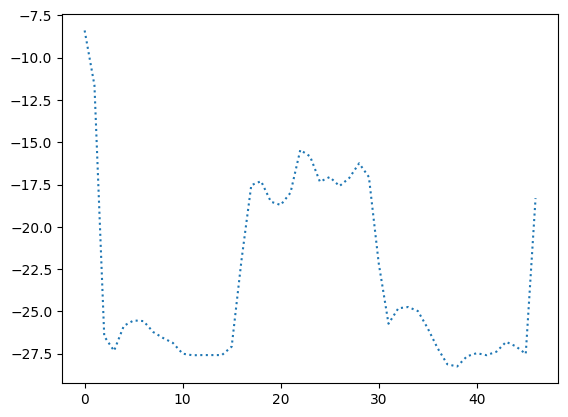

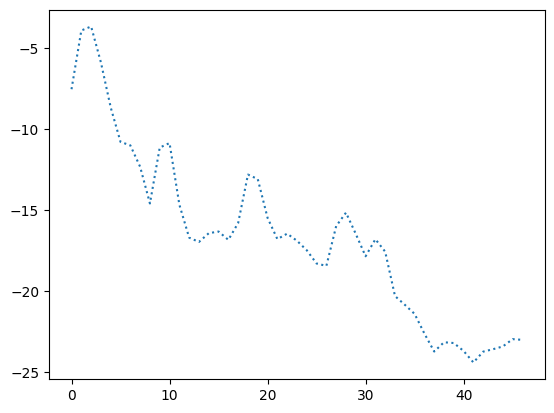

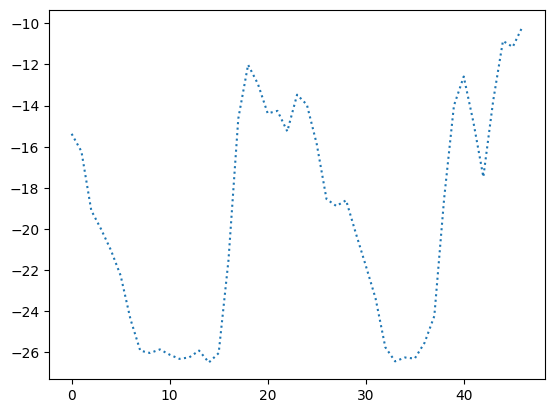

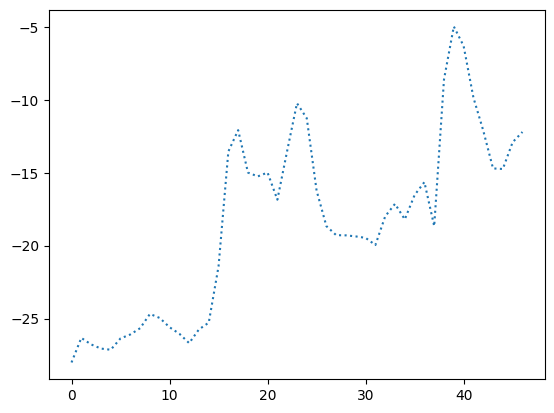

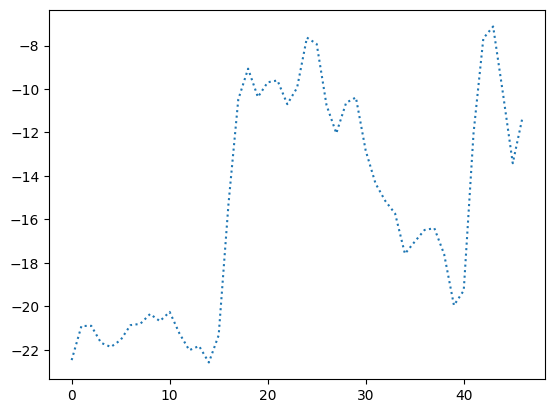

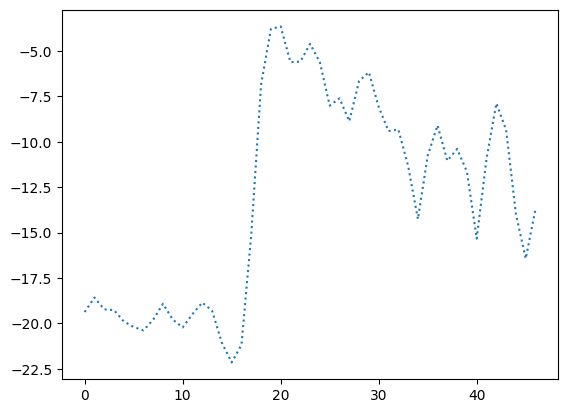

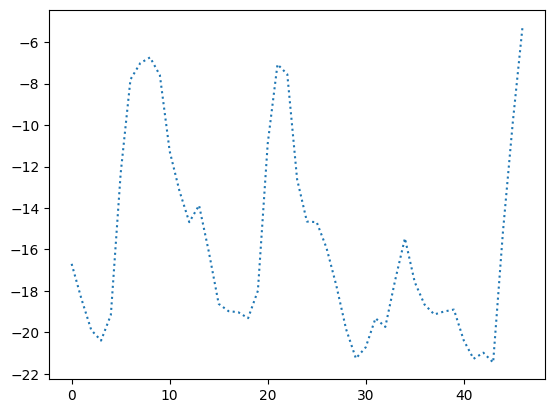

In [175]:
for index in range(10):
    plt.plot(mean_for_each_miniclip_list_np[index], linestyle = 'dotted')
    plt.show()

In [77]:
x_mfcc = np.stack(features)

In [78]:
x_mfcc.shape

(28, 20, 47)

In [79]:
y_two_reviewer_np = np.array(y_two_reviewer_list)

In [80]:
y_two_reviewer_np.shape

(28, 1)

In [81]:
y_two_reviewer_np

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [82]:
# df_pro = pd.DataFrame.from_dict(features)
# df_pro=df_pro.transpose()
# df_pro = df_pro.reset_index()
# df_pro.head()

In [83]:
# df_pro[df_pro["index"] == 'WomenWhoStutter_96_40']

## 3. Output x_mfcc, y_two_reviewer, y_any_reviewer 

In [84]:
# # reshaping the array from 3D matrice to 2D matrice 
# x_mfcc_reshaped = x_mfcc.reshape(x_mfcc.shape[0], -1)
# # saving reshaped array to file.
# np.savetxt("x_mfcc_reshaped.txt", x_mfcc_reshaped)

In [85]:
# # THIS BLOCK CAN BE USED IN MODEL FILE
# # Retrieving data from file.
# LENGTH_OF_THIRD_DIMENSION = 47
# loaded_x_mfcc = np.loadtxt("x_mfcc_reshaped.txt")
# load_original_x_mfcc = loaded_x_mfcc.reshape(loaded_x_mfcc.shape[0], loaded_x_mfcc.shape[1] // LENGTH_OF_THIRD_DIMENSION, LENGTH_OF_THIRD_DIMENSION)
# print("shape of load_original_arr: ", load_original_x_mfcc.shape)

In [86]:
# np.savetxt("y_any_reviewer.txt", y_any_reviewer)

In [87]:
# np.savetxt("y_two_reviewer.txt", y_any_reviewer)

In [88]:
# # THIS BLOCK CAN BE USED IN MODEL FILE
# loaded_y_any_reviewer = np.loadtxt("y_any_reviewer.txt")
# loaded_y_any_reviewer.shape

In [89]:
# # THIS BLOCK CAN BE USED IN MODEL FILE
# loaded_y_two_reviewer = np.loadtxt("y_two_reviewer.txt")
# loaded_y_two_reviewer.shape

In [90]:
import pickle 

# Save the NumPy array as a pickle file
results_path = os.path.join(os.pardir, 'results')
pickle_file_path = os.path.join(results_path, "mfcc_data.pkl")
with open(pickle_file_path, 'wb') as file:
    pickle.dump(x_mfcc, file)

In [91]:
# # Save the y as a pickle file
# pickle_file_path = os.path.join(results_path, "y_any_reviewer.pkl")
# with open(pickle_file_path, 'wb') as file:
#     pickle.dump(y_any_reviewer_np, file)

In [92]:
pickle_file_path = os.path.join(results_path, "y_two_reviewer.pkl")
with open(pickle_file_path, 'wb') as file:
    pickle.dump(y_two_reviewer_np, file)

In [93]:
pickle_file_path = os.path.join(results_path, "clip_name.pkl")
with open(pickle_file_path, 'wb') as file:
    pickle.dump(clip_name_list_np, file)

In [94]:
pickle_file_path = os.path.join(results_path, "y_stutter_feature.pkl")
with open(pickle_file_path, 'wb') as file:
    pickle.dump(y_stutter_feature_np, file)

In [95]:
pickle_file_path = os.path.join(results_path, "x_mfcc_mean.pkl")
with open(pickle_file_path, 'wb') as file:
    pickle.dump(mean_list_np, file)

In [96]:
# pd.DataFrame(y_two_reviewer).to_csv(os.path.join(results_path, 'y_two_reviewer.csv'))
# pd.DataFrame(y_any_reviewer).to_csv(os.path.join(results_path, 'y_any_reviewer.csv'))

In [97]:
# pickle_file_path = os.path.join(results_path, "y_stutter_flag.pkl")
# with open(pickle_file_path, 'wb') as file:
#     pickle.dump(y_stutter_flag_np, file)

### Output Processed data_sep28k_labels File 

In [98]:
# raw_data_directory = os.path.join(os.pardir, 'raw_data')
# data_sep28k_labels.to_csv(os.path.join(raw_data_directory, 'processed_sep28k_fluencybank_labels.csv'))

### TEST PICKLE

In [99]:
# # Loading X
# mfcc_pickle_path = os.path.join(results_path, "mfcc_data.pkl")
# # Load the NumPy array from the pickle file
# with open(mfcc_pickle_path, 'rb') as file:
#     loaded_mfcc_data = pickle.load(file)
# print(loaded_mfcc_data.shape)
# # X_mfcc = loaded_mfcc_data

In [100]:
# # Loading y_any
# y_any_pickle_path = os.path.join(results_path, "y_any_reviewer.pkl")
# # Load the NumPy array from the pickle file
# with open(y_any_pickle_path, 'rb') as file:
#     loaded_y_any_data = pickle.load(file)
# print(loaded_y_any_data.shape)
# print(loaded_y_any_data)

In [101]:
# # Loading y_two
# y_two_pickle_path = os.path.join(results_path, "y_two_reviewer.pkl")
# # Load the NumPy array from the pickle file
# with open(y_two_pickle_path, 'rb') as file:
#     loaded_y_two_data = pickle.load(file)
# print(loaded_y_two_data.shape)
# print(loaded_y_two_data)

In [102]:
# # Loading X
# stutter_feature_pickle_path = os.path.join(results_path, "y_stutter_feature.pkl")
# # Load the NumPy array from the pickle file
# with open(stutter_feature_pickle_path, 'rb') as file:
#     loaded_stutter_feature_data = pickle.load(file)
# print(loaded_stutter_feature_data.shape)
# # X_mfcc = loaded_mfcc_data

In [103]:
# loaded_stutter_feature_data

In [104]:
# # Loading y_stutter_flag
# y_stutter_flag_path = os.path.join(results_path, "y_stutter_flag.pkl")
# # Load the NumPy array from the pickle file
# with open(y_stutter_flag_path, 'rb') as file:
#     loaded_stutter_flag_data = pickle.load(file)
# print(loaded_stutter_flag_data.shape)
# print(loaded_stutter_flag_data)

# PHONET

In [105]:
# ! pip install phonet

In [106]:
# from phonet import Phonet

In [107]:
# results_path = os.path.join(os.pardir, 'results')
# print(results_path)

In [108]:
# # path to clips folder from current Smooth-Talk-Squad folder
# clips_directory = os.path.join(os.pardir,os.pardir, 'clips_by_shows/HVSA')
# print(clips_directory)

In [109]:
# # phon_list = []
# def getPhonProcessData(clips_dir):
#     phon_list = []
#     y_two_reviewer_list =[]
#     for filename in tqdm(os.listdir(clips_directory)):
#         filename = filename[:-4] # Remove file extension (.wav in our situation)
#         if clips_list.count(filename) > 0:
#             # print(os.path.join(clips_directory, filename+'.wav'))        
#             # print(filename)
#             phon=Phonet(["consonantal",
#                         "back",
#                         "anterior",
#                         "open",
#                         "close",
#                         "nasal",
#                         "stop",
#                         "continuant",
#                         "lateral",
#                         "flap",
#                         "trill",
#                         "voice",
#                         "strident",
#                         "labial",
#                         "dental",
#                         "velar",
#                         "pause",
#                         "vocalic"])
            
#             data = phon.get_phon_wav(os.path.join(clips_directory, filename+'.wav'), "" , False)
#             if data.shape == (299,20):
#                 phon_list.append(data)
#                 y_two_reviewer = data_sep28k_labels[data_sep28k_labels["Name"] == filename]["isStutter_by_2_more_reviewers"]
#                 y_two_reviewer_list.append(y_two_reviewer.astype(int))
#             else:
#                 print(f"{filename}:{data.shape}")
#     return (phon_list, y_two_reviewer_list)

In [110]:
# (x_phon, y_phone) = getPhonProcessData(clips_directory)

In [111]:
# type(x_phon)

In [112]:
# phon_np = np.stack(x_phon)

In [113]:
# phon_np.shape

In [114]:
# import pickle 

# # Save the NumPy array as a pickle file
# results_path = os.path.join(os.pardir, 'results')
# pickle_file_path = os.path.join(results_path, "phon_data.pkl")
# with open(pickle_file_path, 'wb') as file:
#     pickle.dump(phon_np, file)